<a id='top'></a><a name='top'></a>
# Custom TFX Component: Model deployment

1. [Introduction](#1.0)
2. [Setup](#2.0)
    * 2.1 [Setup project structure](#2.1)
3. [Testing SavedModels](#1.0)
    * [3.1 Testing inference with tf.keras.models.load_model](#3.1)
        - [3.1.1 Simulation data for images](#3.1.1)
    * [3.2 saved_model_cli tool](#3.2)
4. [Model deployment](#4.0)
    * [4.1 TensorFlow Model Server](#4.1)
        - [4.1.1 Colab TF ModelServer](#4.1.1)
        - [4.1.2 Docker TF ModelServer](#4.1.2)
        - [4.1.3 Start Server](#4.1.3)
        - [4.1.4 Check Server and Logs](#4.1.4)
5. [TensorFlow Model Server - RESTful APIs](#5.0)
    * [5.1 Status API](#5.1)
    * [5.2 Metadata API](#5.2)
    * [5.3 Predict API (simple client)](#5.3)
    * [5.4 Predict API (complex client)](#5.4)

---
<a name='1.0'></a><a id='1.0'></a>
# 1. Introduction
<a href="#top">[back to top]</a>

---
<a name='2.0'></a><a id='2.0'></a>
# 2. Setup
<a href="#top">[back to top]</a>

In [31]:
# stdlib import
import base64
import glob
import os
import os.path
import pprint
from pathlib import Path
import random
import sys
import shlex
import subprocess
import time

# third-party imports
import matplotlib.pyplot as plt
import requests
import tensorflow as tf
from watermark import watermark

# Need to setup again
IN_COLAB = 'google.colab' in sys.modules

%load_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip

# Logging setup
tf.get_logger().propagate = False
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR') # DEBUG, INFO, WARN, ERROR, or FATAL
# logging.set_verbosity(logging.ERROR)

def HR():
    print('-'*40)
    
pp = pprint.PrettyPrinter(indent=2)

HR()
print("VERSION CHECK:")
print()
print(watermark(packages="tfx,tensorflow,apache_beam", python=True,machine=True,hostname=True))

The tfx.orchestration.experimental.interactive.notebook_extensions.skip extension is already loaded. To reload it, use:
  %reload_ext tfx.orchestration.experimental.interactive.notebook_extensions.skip
----------------------------------------
VERSION CHECK:

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.34.0

tfx        : 1.9.1
tensorflow : 2.10.0
apache_beam: 2.39.0

Compiler    : Clang 13.0.0 (clang-1300.0.29.3)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: Georges-MacBook-Air.local



<a name="2.1"></a>
## 2.1 Setup project structure and constants
<a href="#top">[back to top]</a>

In [32]:
# Setup pathways for pipeline (TFX artifact and metadata output)
OUTPUT_ROOT = 'pipeline_output'
PIPELINE_NAME = 'dogs_cats_pipeline'
PIPELINE_ROOT = Path(OUTPUT_ROOT, 'tfx_pipeline_output', PIPELINE_NAME).as_posix()
METADATA_PATH = Path(OUTPUT_ROOT, 'tfx_metadata', PIPELINE_NAME, 'metadata.db').as_posix()
MODEL_NAME = 'my_model'

# Need absolute path for TensorFlow Serving
SERVING_MODEL_DIR = Path(OUTPUT_ROOT, 'tfx_serving_model', PIPELINE_NAME).resolve().as_posix()
LATEST_MODEL = max(glob.glob(os.path.join(SERVING_MODEL_DIR, '*/')), key=os.path.getmtime)
LOG_FILE = f"{MODEL_NAME}_tfs.log"

print(
f"""
OUTPUT_ROOT:\t\t{OUTPUT_ROOT}
PIPELINE_NAME:\t\t{PIPELINE_NAME}
PIPELINE_ROOT:\t\t{PIPELINE_ROOT}
METADATA_PATH:\t\t{METADATA_PATH}
MODEL_NAME:\t\t{MODEL_NAME}

SERVING_MODEL_DIR:\t{SERVING_MODEL_DIR}
LATEST_MODEL:\t\t{LATEST_MODEL}
LOG_FILE:\t\t{LOG_FILE}""")


OUTPUT_ROOT:		pipeline_output
PIPELINE_NAME:		dogs_cats_pipeline
PIPELINE_ROOT:		pipeline_output/tfx_pipeline_output/dogs_cats_pipeline
METADATA_PATH:		pipeline_output/tfx_metadata/dogs_cats_pipeline/metadata.db
MODEL_NAME:		my_model

SERVING_MODEL_DIR:	/Users/gb/Desktop/TFX-CUSTOM-COMPONENTS/custom-components-ok/pipeline_output/tfx_serving_model/dogs_cats_pipeline
LATEST_MODEL:		/Users/gb/Desktop/TFX-CUSTOM-COMPONENTS/custom-components-ok/pipeline_output/tfx_serving_model/dogs_cats_pipeline/1667726973/
LOG_FILE:		my_model_tfs.log


---
<a name='3.0'></a><a id='3.0'></a>
# 3. Testing SavedModels
<a href="#top">[back to top]</a>

<a name='3.1'></a><a id='3.1'></a>
## 3.1 Testing inference with tf.keras.models.load_model
<a href="#top">[back to top]</a>

* Load the exported model and try some inferences with a few examples.
* After the initial loading, this is much faster then `saved_model_cli run`.
* Since we use the same payload format, this is also a better test for a HTTP client REST api call than `saved_model_cli run`.

In [33]:
print("Loading latest model")
loaded_model = tf.keras.models.load_model(LATEST_MODEL)
HR()

inference_fn = loaded_model.signatures['serving_default']
print(type(inference_fn))

Loading latest model
----------------------------------------
<class 'tensorflow.python.saved_model.load._WrapperFunction'>


In [34]:
def _bytes_features(value):
    """Wrapper for inserting bytes feature into Example proto message."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
    
def _convert_to_example(image_buffer):
    """Function to convert image bytes strings into tf.Example
    Args:
        image_buffer: byte string representing the image
    Returns:
        TFExample data structure containing the image (byte string)
    """
    example = tf.train.Example(
        features = tf.train.Features(
            feature = {
                'image/raw' : _bytes_features(image_buffer)
            }
        )
    )
    return example

def get_image_file(filename):
    """Process a single image file
    Args:
        filename: string path to an image
    Returns:
        TFExample data structure containing the image (byte string)
    """
    byte_content = tf.io.read_file(filename)
    rs = _convert_to_example(byte_content.numpy())
    return rs



#INPUT = 'https://tensorflow.org/images/blogs/serving/dog.jpg'
#INPUT = "pipeline_data/PetImages/Dog/9554.jpg"
INPUT = 'pipeline_data/PetImages/Cat/9733.jpg'


# Creating a tf.Example standard proto storing data for training and inference.
# https://www.tensorflow.org/api_docs/python/tf/train/Example
example_image: tf.train.Example = get_image_file(INPUT)
print(f"example_image: {type(example_image)}")
HR()

# After serialization
# Serializes a proto message to a binary-string
# https://developers.google.com/protocol-buffers/docs/pythontutorial#parsing-and-serialization
example_bytes: bytes = example_image.SerializeToString()
print(f"examples type: {type(example_bytes)}")
HR()

# The SavedModel target here (accessed directly) expects a Tensor in the examples argument.
# To enable this, we need to wrap it via `tf.constant([examples])`, 
# where tf.constant creates a constant tensor from a tensor-like object:
# https://www.tensorflow.org/api_docs/python/tf/constant
example_tensor = tf.constant([example_bytes]) # can also use tf.convert_to_tensor
print(f"example_tensor type: {type(example_tensor)}")
HR()

result = inference_fn(examples=example_tensor)
print(result['outputs'].numpy())

example_image: <class 'tensorflow.core.example.example_pb2.Example'>
----------------------------------------
examples type: <class 'bytes'>
----------------------------------------
example_tensor type: <class 'tensorflow.python.framework.ops.EagerTensor'>
----------------------------------------
[[-3.2321565]]


<a name='3.1.1'></a><a id='3.1.1'></a>
### 3.1.1 Simulation data for images
<a href="#top">[back to top]</a>

Simulation datasets created from `tf.random`.

https://www.tensorflow.org/api_docs/python/tf/random/normal

In [35]:
DATA_WIDTH=160
DATA_HEIGHT=160
DATA_CHANNEL=3

In [36]:
def show_img(input):
    input = tf.reshape(input, [DATA_WIDTH, DATA_WIDTH, DATA_CHANNEL])
    fig = plt.figure()
    ax = fig.add_subplot()
    _, _, channel = (input.shape)
    if channel == 1:
        cmap = 'gray'
    else:
        cmap = 'viridis'
    ax.imshow(input, cmap=cmap)  
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'tensorflow.python.framework.ops.EagerTensor'>
(160, 160, 3)
[0.33566386 1.0220386  0.30627787]


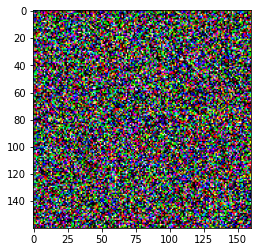

In [37]:
# Outputs random values from a normal distribution
data_normal = tf.random.normal(
    [DATA_WIDTH, DATA_HEIGHT, DATA_CHANNEL],
    mean=0.0,
    stddev=1.0,
    dtype=tf.dtypes.float32,
    seed=None,
    name=None
)

print(type(data_normal))
print(data_normal.shape)
print(data_normal[0,0,:].numpy())
show_img(data_normal)

**Test with artificial data-set**

In [38]:
def get_simulation_data(input):
    """Process non-jpeg image-simulation data
    Args:
        input: tensor
    Returns:
        TFExample data structure containing the image (byte string)
    """
    rs = _convert_to_example(input)
    return rs


print("Original data:")
print(type(data_normal))
HR()

# Transforms a Tensor into a serialized TensorProto proto.
# Transforms data in a tf.Tensor into a tf.Tensor of type tf.string containing the data in a binary string format.
# https://www.tensorflow.org/api_docs/python/tf/io/serialize_tensor
tensorByteProto = tf.io.serialize_tensor(data_normal)
print("tensorByteProto:")
print(type(tensorByteProto))
HR()

# Creating a tf.Example standard proto storing data for training and inference.
# https://www.tensorflow.org/api_docs/python/tf/train/Example
example_image: tf.train.Example = get_simulation_data(tensorByteProto.numpy())
print("EXAMPLE_IMAGE")
print(type(example_image))
HR()

# After serialization
# Serializes a proto message to a binary-string
# https://developers.google.com/protocol-buffers/docs/pythontutorial#parsing-and-serialization
# We can also use example_bytes for the HTTP REQUEST
example_bytes: bytes = example_image.SerializeToString()
print(f"examples type: {type(example_bytes)}")
HR()

# The SavedModel target here (accessed directly) expects a Tensor in the examples argument.
# To enable this, we need to wrap it via `tf.constant([examples])`, 
# where tf.constant creates a constant tensor from a tensor-like object:
# https://www.tensorflow.org/api_docs/python/tf/constant
example_tensor = tf.constant([example_bytes]) # can also use tf.convert_to_tensor
print(f"example_tensor type: {type(example_tensor)}")
HR()


result = inference_fn(examples=example_tensor)
print(result['outputs'].numpy())

Original data:
<class 'tensorflow.python.framework.ops.EagerTensor'>
----------------------------------------
tensorByteProto:
<class 'tensorflow.python.framework.ops.EagerTensor'>
----------------------------------------
EXAMPLE_IMAGE
<class 'tensorflow.core.example.example_pb2.Example'>
----------------------------------------
examples type: <class 'bytes'>
----------------------------------------
example_tensor type: <class 'tensorflow.python.framework.ops.EagerTensor'>
----------------------------------------
[[-0.32448944]]


<a name='3.2'></a><a id='3.2'></a>
## 3.2 saved_model_cli tool
<a href="#top">[back to top]</a>

In general, this is useful to examine the contents of the SavedModel via `saved_model_cli show ..`, such as showing tag-sets, available SignatureDef keys for a tag set, inputs and outputs TensorInfo for a specific SignatureDef, etc.

However, testing inference  seems much easier via the above `tf.keras.models.load_model` operation.

In [39]:
print("Show all tag-sets in SavedModel:\n")
!saved_model_cli show --dir {LATEST_MODEL}
HR()

print("Show all available SignatureDef keys in the MetaGraphDef specified by tag-set 'serve':\n")
!saved_model_cli show --dir {LATEST_MODEL} --tag_set serve
HR()

print("Show all inputs and outputs TensorInfo for the specific SignatureDef 'serving_default' in the MetaGraph:")
!saved_model_cli show --dir {LATEST_MODEL} --tag_set serve --signature_def serving_default

Show all tag-sets in SavedModel:

2022-11-08 12:26:07.731570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
The given SavedModel contains the following tag-sets:
'serve'
----------------------------------------
Show all available SignatureDef keys in the MetaGraphDef specified by tag-set 'serve':

2022-11-08 12:26:25.433424: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
Signature

---
<a name='4.0'></a><a id='4.0'></a>
# 4. Model deployment
<a href="#top">[back to top]</a>

<a name='4.1'></a><a id='4.1'></a>
## 4.1 TensorFlow ModelServer
<a href="#top">[back to top]</a>

Resources:

* https://github.com/tensorflow/serving/blob/master/tensorflow_serving/tools/docker/Dockerfile

<a name='4.1.1'></a><a id='4.1.1'></a>
### 4.1.1 Colab TF ModelServer
<a href="#top">[back to top]</a>

```
TensorFlow ModelServer: 2.8.0-rc1+dev.sha.9400ef1
TensorFlow Library: 2.8.0
```

In [40]:
def tfs_download_colab():
    print("Running on Colab")
    HR()

    # tensorflow-model-server 2.8.2 and 2.9.0 require updated GLIBC versions.
    # https://github.com/tensorflow/serving/blob/master/tensorflow_serving/g3doc/setup.md
    
    # Binary debian file
    debian_tfs = 'tensorflow-model-server-universal_2.8.0_all.deb'
    path = Path(debian_tfs)
    if not path.is_file():
        !wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'

    # Use dpkg to install, remove, and provide information about .deb packages.
    !dpkg -i tensorflow-model-server-universal_2.8.0_all.deb


def tfs_start_colab():
    # Use `subprocess.Popen()` to start the tensorflow_model_server. The subprocess module allows you to spawn new processes, connect to their input/output/error pipes, and obtain their return codes.
    # To run `tensorflow_model_server` as a process on Debian, we additionaly need these steps:

    # * https://stackoverflow.com/questions/6011235/run-a-program-from-python-and-have-it-continue-to-run-after-the-script-is-kille/16928558#16928558
    # Run a program from python, and have it continue to run after the script is killed. If use 'setpgrp', this prevents the child from getting SIGHUP from the parent, since it's no longer part of the same process group, hence cannot use 'nohup',
    # but we really don't need it anymore.
    
    # By default, TensorFlow Model Server listens on port 8500 using the gRPC API. To use a different port, specify --port=<port number> on the command line.
    # By default TensorFlow Model Server will not listen for a REST/HTTP request. To specify a port to listen for a REST/HTTP request, include --rest_api_port=<port number> on the command line.

    # Can we directly pass environmental variables here?
    cmd = f"""nohup 
        tensorflow_model_server 
        --rest_api_port=8501 
        --model_name={model_name} 
        --model_base_path='{SERVING_MODEL_DIR}' 
        """

    try:
        # Run a program from python, and have it continue to run after the script is killed
        # https://stackoverflow.com/questions/6011235/run-a-program-from-python-and-have-it-continue-to-run-after-the-script-is-kille/16928558#16928558
        # If use 'setpgrp', this prevents the child from getting SIGHUP from the parent, 
        # since it's no longer part of the same process group, hence cannot use 'nohup',
        # but we really don't need it anymore.
        # popen on Unix is done using fork, so it naturally "detaches" from the parent process
        proc = subprocess.Popen(
            shlex.split(cmd),
            stdout=open(log_file, 'w'),
            stderr=subprocess.STDOUT,
            preexec_fn=os.setpgrp, # keep subprocess alive even when parent stops
            shell=False # needed for shell-like features like &
        )

    except Exception as e:
        print(f"Error: {e}")

    return proc


def check_tfp_process():
    !ps ax | grep -e tensorflow_model_server

<a name='4.1.2'></a><a id='4.1.2'></a>
### 4.1.2 Docker TF ModelServer
<a href="#top">[back to top]</a>

* https://hub.docker.com/r/tensorflow/serving

Make sure to match the version running on Colab, which currently is `2.8.0-rc1-devel`

In [41]:
cmd_cli = f"""
docker run \\
--rm --tty -p 8500:8500 -p 8501:8501 \\
--name {MODEL_NAME} \\
--mount type=bind,source={SERVING_MODEL_DIR},target=/models/{MODEL_NAME} \\
--env MODEL_NAME={MODEL_NAME} \\
--env TF_CPP_VMODULE='http_server=1' \\
--log-driver=json-file \\
--log-opt=mode=non-blocking \\
--detach \\
tensorflow/serving:2.8.0
"""

print(cmd_cli)
HR()


# Another variation
cmd_cli2 = f"""
docker run  \\
--rm --tty -p 8500:8500 -p 8501:8501 \\
-v "{SERVING_MODEL_DIR}:/models/{MODEL_NAME}" \\
--env MODEL_NAME={MODEL_NAME} \\
--env TF_CPP_VMODULE='http_server=1' \\
--log-driver=json-file \\
--log-opt=mode=non-blocking \\
--detach \\
tensorflow/serving:2.8.0
"""

print(cmd_cli2)


docker run \
--rm --tty -p 8500:8500 -p 8501:8501 \
--name my_model \
--mount type=bind,source=/Users/gb/Desktop/TFX-CUSTOM-COMPONENTS/custom-components-ok/pipeline_output/tfx_serving_model/dogs_cats_pipeline,target=/models/my_model \
--env MODEL_NAME=my_model \
--env TF_CPP_VMODULE='http_server=1' \
--log-driver=json-file \
--log-opt=mode=non-blocking \
--detach \
tensorflow/serving:2.8.0

----------------------------------------

docker run  \
--rm --tty -p 8500:8500 -p 8501:8501 \
-v "/Users/gb/Desktop/TFX-CUSTOM-COMPONENTS/custom-components-ok/pipeline_output/tfx_serving_model/dogs_cats_pipeline:/models/my_model" \
--env MODEL_NAME=my_model \
--env TF_CPP_VMODULE='http_server=1' \
--log-driver=json-file \
--log-opt=mode=non-blocking \
--detach \
tensorflow/serving:2.8.0



In [42]:
def server_docker():  
        
    # Using the tensorflow/serving:latest image causes an error
    
    cmd = f"""
        docker run
        --rm --tty -p 8500:8500 -p 8501:8501
        --name {MODEL_NAME}
        --mount type=bind,source={SERVING_MODEL_DIR},target=/models/{MODEL_NAME}
        --env MODEL_NAME={MODEL_NAME}
        --env TF_CPP_VMODULE='http_server=1'
        --log-driver=json-file
        --log-opt=mode=non-blocking
        --detach
        tensorflow/serving:2.8.0
        """
               
    try:
        proc = subprocess.Popen(
            shlex.split(cmd),
            stdout = subprocess.PIPE,
            stderr = subprocess.PIPE
        )
        
        # The communicate() method returns a tuple (stdoutdata, stderrdata)
        # It only reads data from stdout and stderr.
        out, err = proc.communicate()
        out = out.decode()
        err = err.decode()
        print(f"out: {(out.strip())}")
        
        if err:
            print(f"err: {err}")
                
        sleep_time = 0.5 # Small time delay for docker instance to start up
        time.sleep(sleep_time)
        
    except subprocess.CalledProcessError as e:
        print(f"Subprocess error: {e.stderr}")
    except Exception as e:
        print(f"Error: {e}")
        
    return proc 

<a name='4.1.3'></a><a id='4.1.3'></a>
### 4.1.3 Start Server
<a href="#top">[back to top]</a>

In [43]:
if IN_COLAB:
    print("Running COLAB server")
    tfs_download_colab() # download
    proc = tfs_start_colab() # start
    !tensorflow_model_server --version
    print(f"tensorflow_model_server proc.pid: {proc.pid}")
    check_tfp_process() # check if running
else:
    print("Running Docker server")
    # Instantiate TFS with our model 
    proc = server_docker() 

Running Docker server
out: 6058fc002ae3e9bce28a320b73ae3d686475ec0f92447187a27d8ca49d7b71cc
----------------------------------------


In [44]:
def show_tfs_dict(proc):
    print("Properties of returned container process:\n")
    for key in proc.__dict__:
        if key == 'args':
            HR()
            print(key, '->', proc.__dict__[key])
            HR()
        else:
            print(key, '->', proc.__dict__[key])

In [45]:
show_tfs_dict(proc)

Properties of returned container process:

_waitpid_lock -> <unlocked _thread.lock object at 0x12f9e3240>
_input -> None
_communication_started -> True
----------------------------------------
args -> ['docker', 'run', '--rm', '--tty', '-p', '8500:8500', '-p', '8501:8501', '--name', 'my_model', '--mount', 'type=bind,source=/Users/gb/Desktop/TFX-CUSTOM-COMPONENTS/custom-components-ok/pipeline_output/tfx_serving_model/dogs_cats_pipeline,target=/models/my_model', '--env', 'MODEL_NAME=my_model', '--env', 'TF_CPP_VMODULE=http_server=1', '--log-driver=json-file', '--log-opt=mode=non-blocking', '--detach', 'tensorflow/serving:2.8.0']
----------------------------------------
stdin -> None
stdout -> <_io.BufferedReader name=94>
stderr -> <_io.BufferedReader name=96>
pid -> 1807
returncode -> 0
encoding -> None
errors -> None
text_mode -> None
_sigint_wait_secs -> 0.25
_closed_child_pipe_fds -> True
_child_created -> True
_fileobj2output -> {<_io.BufferedReader name=94>: [b'6058fc002ae3e9bce28a3

<a name='4.1.4'></a><a id='4.1.4'></a>
### 4.1.4 Check Server and Logs
<a href="#top">[back to top]</a>

In [46]:
# Wait for the TFMS-docker server to spin up
time.sleep(5)

for x in range(10):    
    try:
        resp_data = requests.get(f'http://localhost:8501/v1/models/{MODEL_NAME}')
        print(f"===> TFS Status : {resp_data.headers['Date']} {resp_data}")
        time.sleep(0.2)
    except Exception as e:
        print(f"Error: {e}")

HR()
    
!du -h {LOG_FILE}
HR()
!tail -10 {LOG_FILE}

===> TFS Status : Tue, 08 Nov 2022 03:26:53 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:53 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:53 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:53 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:54 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:54 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:54 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:54 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:54 GMT <Response [200]>
===> TFS Status : Tue, 08 Nov 2022 03:26:55 GMT <Response [200]>
----------------------------------------
du: my_model_tfs.log: No such file or directory
----------------------------------------
tail: my_model_tfs.log: No such file or directory


In [47]:
check_tfp_process() # check if running

 1811 s002  Ss+    0:00.02 /bin/zsh -c ps ax | grep -e tensorflow_model_server
 1813 s002  R+     0:00.00 grep -e tensorflow_model_server


---
<a name="5.0"></a>
# 5. TensorFlow Model Server - RESTful APIs
<a href="#top">[back to top]</a>

Send requests with TensorFlow ModelServer RESTful APIs

<a name="5.1"></a>
## 5.1 Status API
<a href="#top">[back to top]</a>

* Returns the status of a model in the ModelServer.
* If successful, returns a JSON representation of `GetModelStatusResponse` protobuf.

In [48]:
compact=False

url_model = f"http://localhost:8501/v1/models/{MODEL_NAME}"
print(url_model)
HR()

try:
    resp_data = requests.get(url_model)
except Exception as e:
    print(f"Error: {e}")

pp.pprint(resp_data.json())

http://localhost:8501/v1/models/my_model
----------------------------------------
{ 'model_version_status': [ { 'state': 'AVAILABLE',
                              'status': { 'error_code': 'OK',
                                          'error_message': ''},
                              'version': '1667726973'}]}


<a name="5.2"></a>
## 5.2 Metadata API
<a href="#top">[back to top]</a>

* Returns the metadata of a model in the ModelServer. For example, we can inspect the details of the input and output tensors.
* Returns a JSON representation of `GetModelMetadataResponse` protobuf.

In [49]:
url_metadata = f"http://localhost:8501/v1/models/{MODEL_NAME}/metadata"
print(url_metadata)
HR()

try:
    resp_data = requests.get(url_metadata)
except Exception as e:
    print(f"Error: {e}")

json_dump = (resp_data.json())
pp.pprint(repr(json_dump))

http://localhost:8501/v1/models/my_model/metadata
----------------------------------------
("{'model_spec': {'name': 'my_model', 'signature_name': '', 'version': "
 "'1667726973'}, 'metadata': {'signature_def': {'signature_def': "
 "{'serving_default': {'inputs': {'examples': {'dtype': 'DT_STRING', "
 "'tensor_shape': {'dim': [{'size': '-1', 'name': ''}], 'unknown_rank': "
 "False}, 'name': 'serving_default_examples:0'}}, 'outputs': {'outputs': "
 "{'dtype': 'DT_FLOAT', 'tensor_shape': {'dim': [{'size': '-1', 'name': ''}, "
 "{'size': '1', 'name': ''}], 'unknown_rank': False}, 'name': "
 "'StatefulPartitionedCall:0'}}, 'method_name': 'tensorflow/serving/predict'}, "
 "'__saved_model_init_op': {'inputs': {}, 'outputs': {'__saved_model_init_op': "
 "{'dtype': 'DT_INVALID', 'tensor_shape': {'dim': [], 'unknown_rank': True}, "
 "'name': 'NoOp'}}, 'method_name': ''}}}}}")


<a name="5.3"></a>
## 5.3 Predict API (simple client)
<a href="#top">[back to top]</a>

* The request body for predict API must be JSON object formatted as follows (for clarity, it may be easier to always include the "signature_name" field)
* There are three base Feature types:
    - tf.train.BytesList
    - tf.train.FloatList
    - tf.train.Int64List
* Fundamentally, a tf.train.Example is a {"string": tf.train.Feature} mapping.
* TensorFlow Serving expects the input data as a JSON data structure.
* Create a Features message using tf.train.Example. The tf.train.Example message (or protobuf) is a flexible message type that represents a  {"string": value} mapping. It is designed for use with TensorFlow and is used throughout TFX.

Resources:

* https://www.tensorflow.org/tfx/tutorials/tfx/penguin_tft

---

If we look at this code in the saved model:

<font size=2>
    
```python
def _get_serve_tf_examples_fn(model, tf_transform_output):
    model.tft_layer = tf_transform_output.transform_features_layer()

    @tf.function
    def serve_tf_examples_fn(serialized_tf_examples):
        feature_spec = tf_transform_output.raw_feature_spec()
        feature_spec.pop(LABEL_KEY)
        parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
        transformed_features = model.tft_layer(parsed_features)
        outputs = model(transformed_features)
        return {"outputs": outputs}
    return serve_tf_examples_fn
```

</font>
<br>

we can see that the input needs to be in serialized TF Example format. 

In particular, `tf.io.parse_example()` parses Example protos into a dict of tensors.
- https://www.tensorflow.org/api_docs/python/tf/io/parse_example

Hence this defines the format of data sent from our HTTP client. 

After preparing data as tf.Example, we then have to serialize it for transport via JSON. For this, we can use `json.dumps()`, which serializes obj to a JSON formatted str. Or, we can use `base64.b64encode`, which encodes the bytes-like objects using Base64 and returns the encoded bytes.

In [50]:
# Python client for TensorFlow Model Server
# We need to manually serialize the tf.Example here
def client_simple(example_bytes):
    
    # The SavedModel target here (via TensorFlow Serving) expects serialized examples in json format.
    # To enable this, we use base64.b64encode(example_bytes).decode('utf-8')
    # If inputs is a scaler shape, may need to use this format:
    # "inputs": {"examples": {"b64": base64.b64encode(example_proto).decode('utf-8')}} 
    # Also note, since we use base64.b64encode here, we don't use json.dumps
    example_json = {
        "signature_name": "serving_default",
        "inputs": {"examples": [{"b64": base64.b64encode(example_bytes).decode('utf-8')}]} # 1-D format
    }

    # print("Our payload, after base64 encoding and serialization:\n")
    # print(example_json)
    # HR()
    
    model_server_url = f"http://localhost:8501/v1/models/{MODEL_NAME}:predict"
    print(model_server_url)
    HR()
    
    headers = {"content-type": "application/json"}
    resp = requests.post(model_server_url, json=example_json, headers=headers)
    print("resp.json():")
    print(resp.json())
    HR()
    print("resp:")
    print(resp)

try:
    client_simple(example_bytes)
except Exception as e:
    print(f"Error: {e}")
    

http://localhost:8501/v1/models/my_model:predict
----------------------------------------
resp.json():
{'outputs': [[-0.324489027]]}
----------------------------------------
resp:
<Response [200]>
